In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
def get_linear_data(n: int = 1000) -> torch.tensor:
    X = torch.normal(0.0, 1, (n, 2))
    A = torch.tensor([[1, 2], [-0.1, 0.5]])
    b = torch.tensor([1, 2])
    data = torch.matmul(X, A) + b
    return data

In [3]:
data = get_linear_data()
dataloader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(data),
        batch_size=8, shuffle=True)

In [4]:
latent_dim = 2
input_dim = data.shape[1]

generator = nn.Sequential(
    nn.Linear(latent_dim, input_dim)
)

discriminator = nn.Sequential(
    nn.Linear(input_dim, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
)

In [5]:
def update_discriminator(x, z, D, G, criterion, trainer_D):
    """Update discriminator."""
    batch_size = x.shape[0]
    ones = torch.ones((batch_size,), device=x.device)
    zeros = torch.zeros((batch_size,), device=x.device)

    trainer_D.zero_grad()

    real_y = D(x)
    fake_y = D(G(z))
    loss_D = (criterion(real_y, ones.reshape(real_y.shape)) +
                          criterion(fake_y, zeros.reshape(fake_y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [6]:
def update_generator(z, D, G, criterion, trainer_G):
    """Update generator."""
    batch_size = z.shape[0]
    ones = torch.ones((batch_size,), device=z.device)

    trainer_G.zero_grad()

    fake_y = D(G(z))
    loss_G = criterion(fake_y, ones.reshape(fake_y.shape))
    loss_G.backward()
    trainer_G.step()
    return  loss_G

In [7]:
def train_gan(D, G, dataloader, data, num_epochs, lr_G, lr_D, latent_dim, fixed_noise, visualize=False, print_every=25):
    loss = nn.BCEWithLogitsLoss(reduction="sum")
    #for w in D.parameters(): nn.init.normal_(w, 0., 0.02)
    #for w in G.parameters(): nn.init.normal_(w, 0., 0.02)
    trainer_D = torch.optim.Adam(D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(G.parameters(), lr=lr_G)

    metrics = []
    os.makedirs("visualizations", exist_ok=True)
    for epoch in range(num_epochs):
        loss_D = 0
        loss_G = 0
        num_instances = 0
        for step_num, (X,) in enumerate(dataloader):
            batch_size = X.shape[0]
            num_instances += batch_size
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            loss_D += update_discriminator(X, Z, D, G, loss, trainer_D).item() * batch_size
            loss_G += update_generator(Z, D, G, loss, trainer_G).item() * batch_size
            # if step_num % print_every == 0:
            #     print(f"[Epoch {epoch+1}/{num_epochs}] [Step {step_num}/{len(dataloader)}] loss_D: {loss_D/num_instances:.5f}, loss_G: {loss_G/num_instances:.5f}")

        loss_G /= num_instances
        loss_D /= num_instances
        metrics.append([loss_D, loss_G])
        print(f"[Epoch {epoch+1}/{num_epochs}] loss_D: {loss_D:.5f}, loss_G: {loss_G:.5f}")

        if visualize:
            # Z = torch.normal(0, 1, size=(100, latent_dim))
            fake_data = G(fixed_noise).detach().numpy()
            plt.scatter(data[:, 0], data[:, 1], label="real")
            plt.scatter(fake_data[:, 0], fake_data[:, 1], label="generated")
            plt.legend(["real", "generated"])
            plt.savefig(f"visualizations/{epoch:02d}.png")
            plt.show()
            plt.close()

    metrics = np.array(metrics)

    plt.plot(metrics[:, 0], label="discriminator")
    plt.plot(metrics[:, 1], label="generator", linestyle="--")
    plt.legend()
    plt.ylabel("loss")
    plt.show()

[Epoch 1/30] loss_D: 7.68243, loss_G: 20.67623


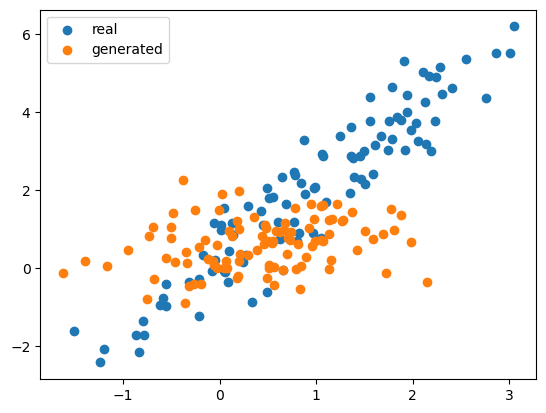

[Epoch 2/30] loss_D: 8.26355, loss_G: 18.45409


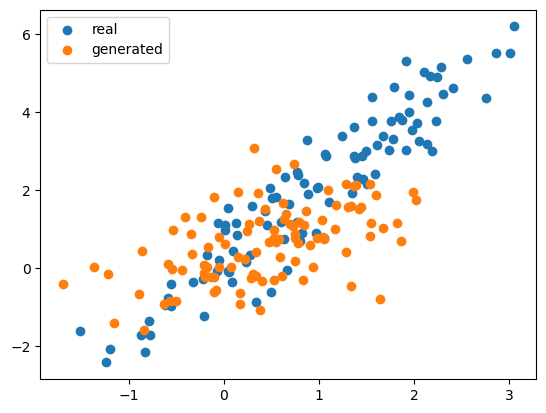

[Epoch 3/30] loss_D: 9.41820, loss_G: 15.27578


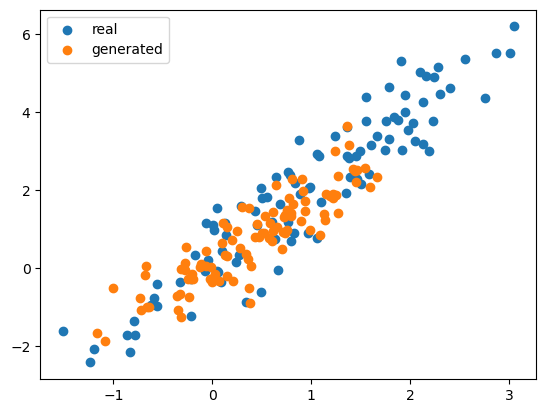

[Epoch 4/30] loss_D: 9.77166, loss_G: 13.94031


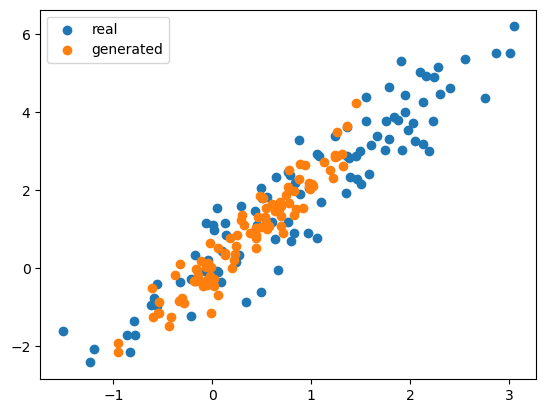

[Epoch 5/30] loss_D: 10.22382, loss_G: 13.24662


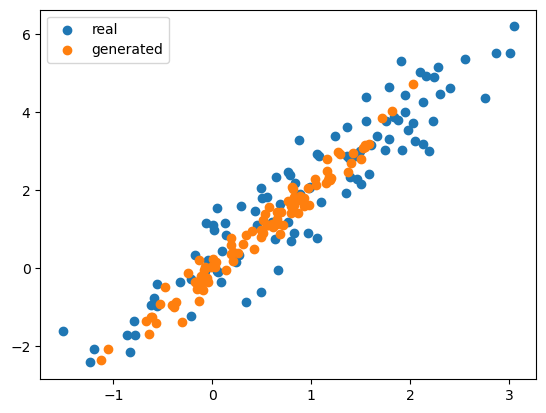

[Epoch 6/30] loss_D: 10.48392, loss_G: 12.54824


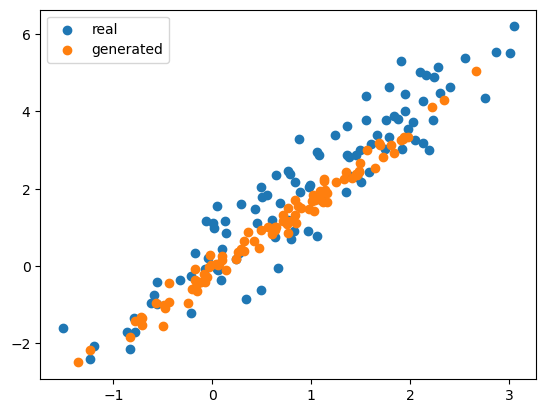

[Epoch 7/30] loss_D: 10.63194, loss_G: 12.06157


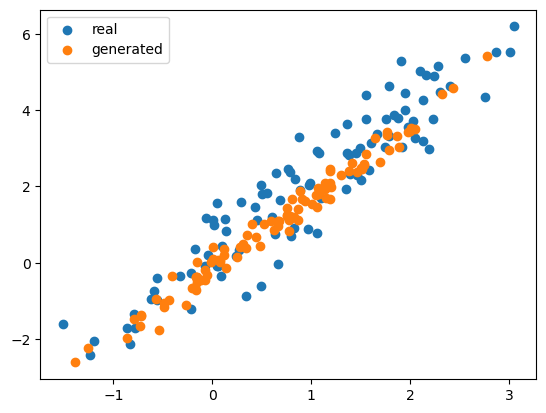

[Epoch 8/30] loss_D: 10.87475, loss_G: 11.58343


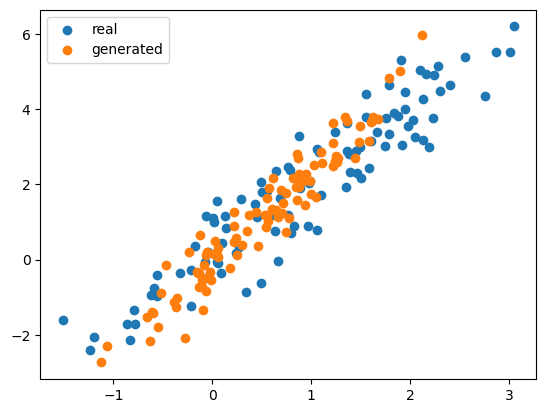

[Epoch 9/30] loss_D: 10.98739, loss_G: 11.21060


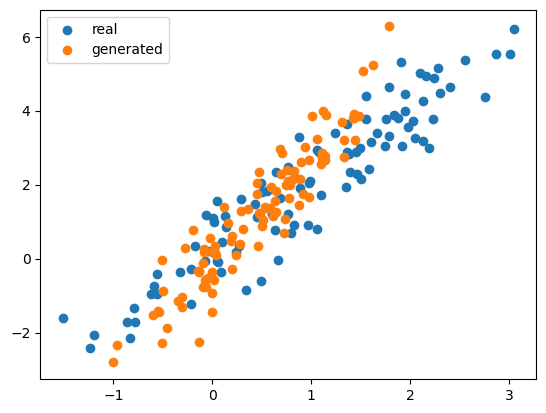

[Epoch 10/30] loss_D: 10.74668, loss_G: 11.85110


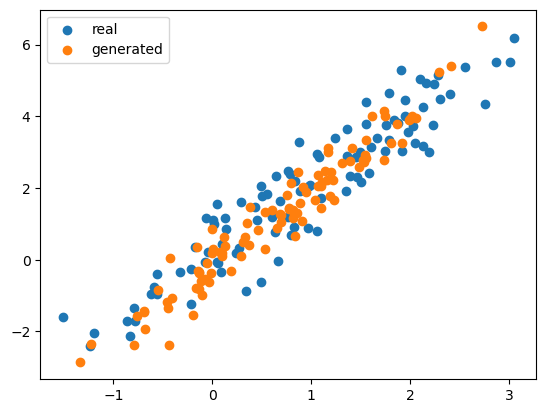

[Epoch 11/30] loss_D: 11.04743, loss_G: 11.17594


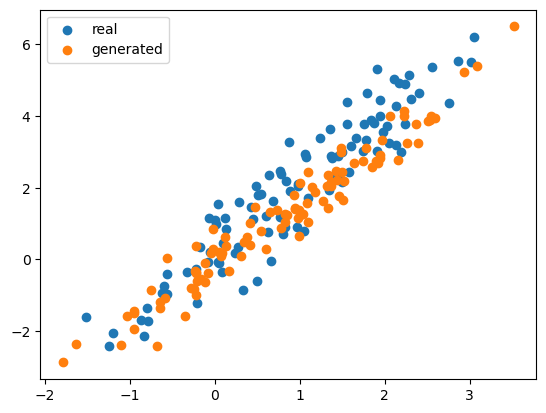

[Epoch 12/30] loss_D: 11.04702, loss_G: 11.03781


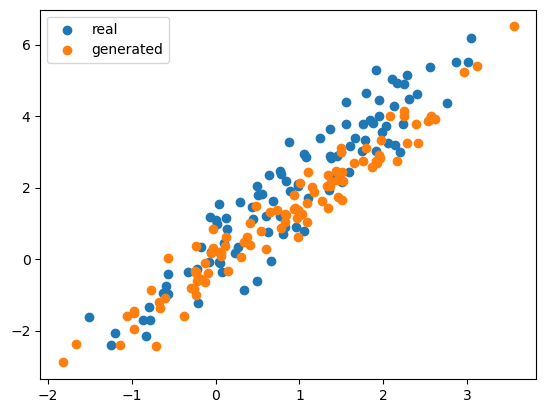

[Epoch 13/30] loss_D: 11.04781, loss_G: 11.04416


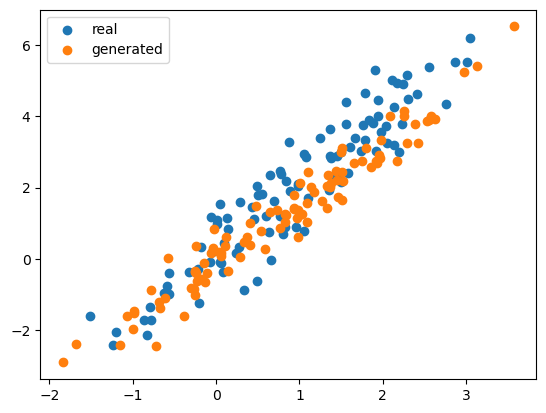

[Epoch 14/30] loss_D: 11.04643, loss_G: 11.04612


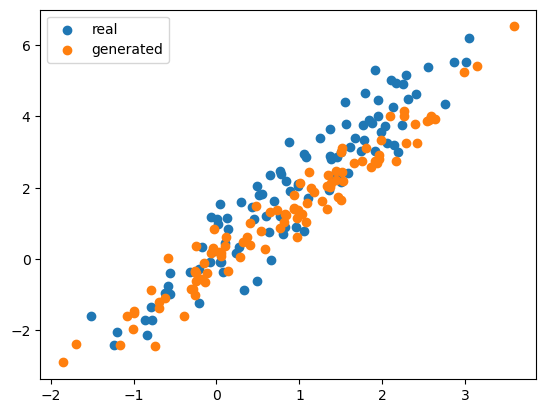

[Epoch 15/30] loss_D: 11.04767, loss_G: 11.04242


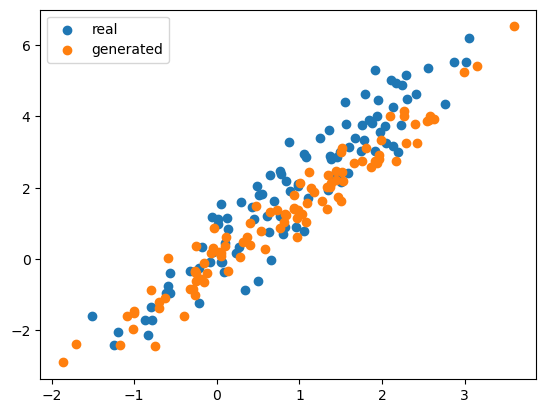

[Epoch 16/30] loss_D: 11.04658, loss_G: 11.04545


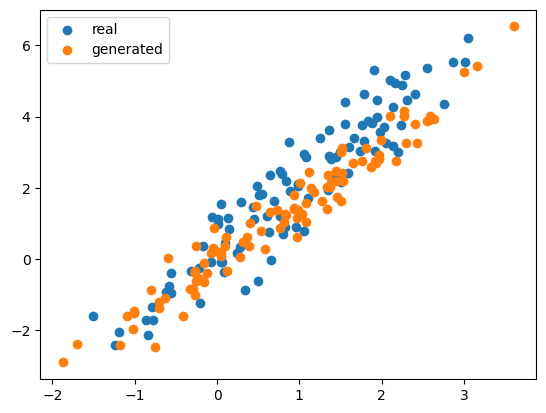

[Epoch 17/30] loss_D: 11.04617, loss_G: 11.04572


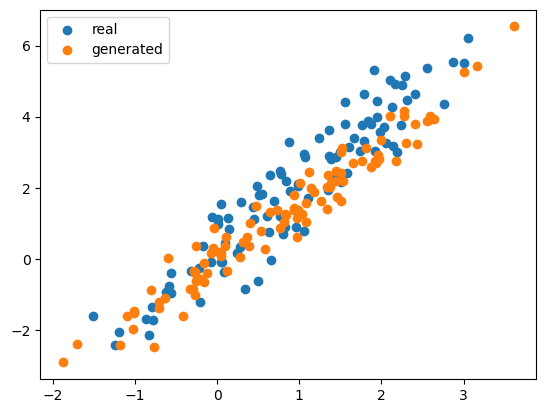

[Epoch 18/30] loss_D: 11.04629, loss_G: 11.04573


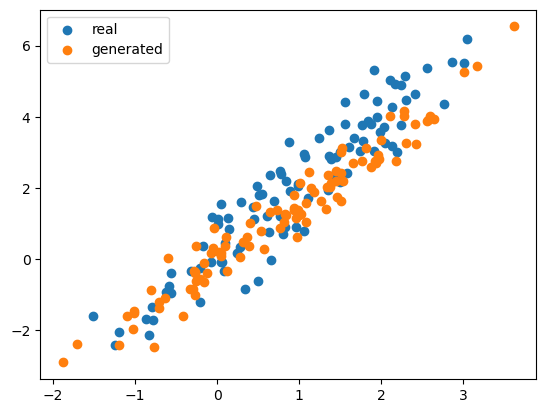

[Epoch 19/30] loss_D: 11.04549, loss_G: 11.04702


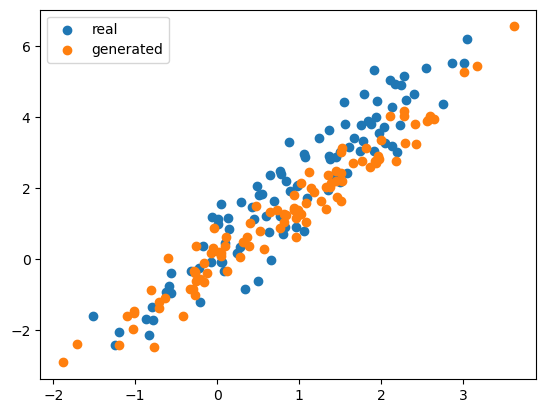

[Epoch 20/30] loss_D: 11.04629, loss_G: 11.04512


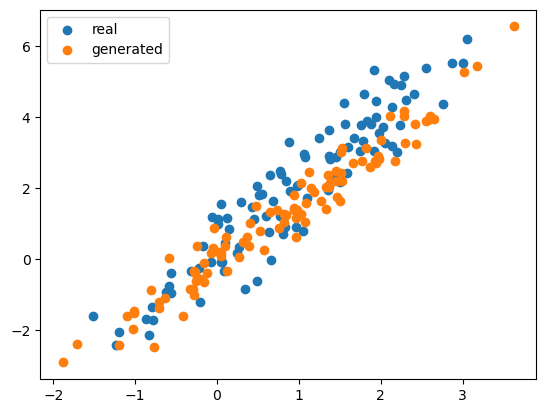

[Epoch 21/30] loss_D: 11.04591, loss_G: 11.04648


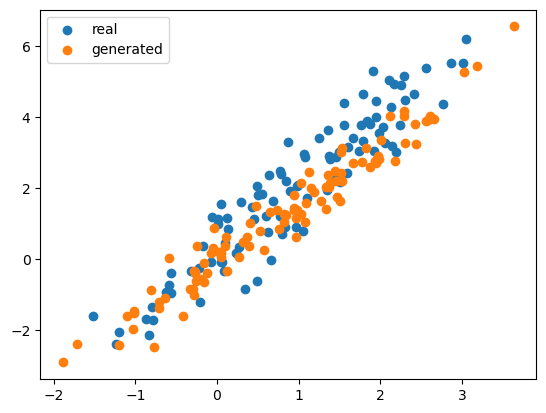

[Epoch 22/30] loss_D: 11.04550, loss_G: 11.04693


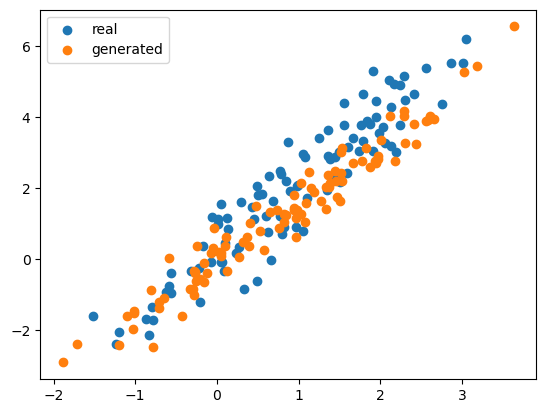

[Epoch 23/30] loss_D: 11.04565, loss_G: 11.04669


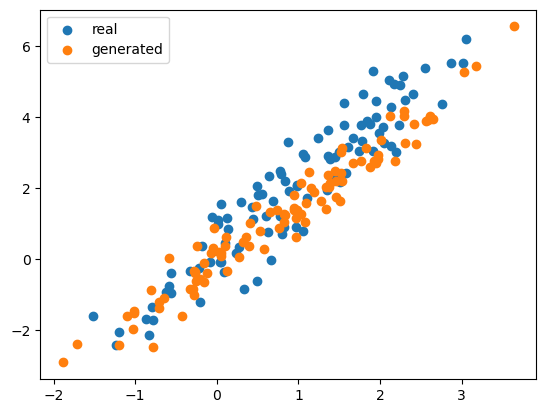

[Epoch 24/30] loss_D: 11.04481, loss_G: 11.04818


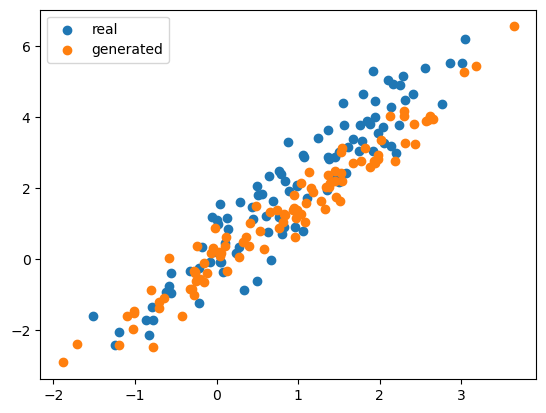

[Epoch 25/30] loss_D: 11.04084, loss_G: 11.05285


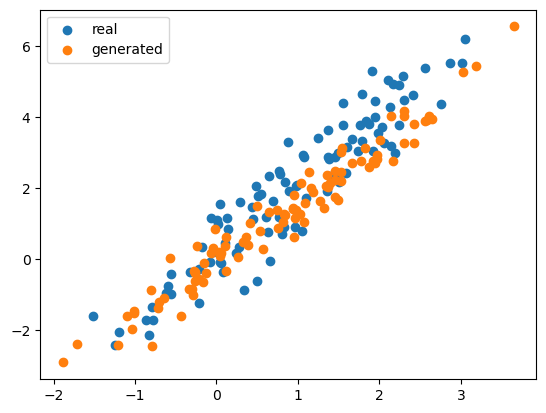

[Epoch 26/30] loss_D: 11.04023, loss_G: 11.18896


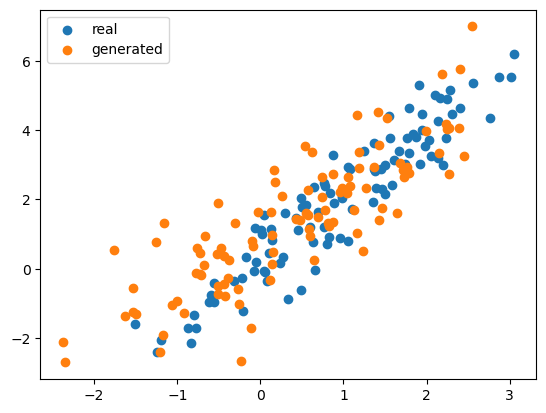

[Epoch 27/30] loss_D: 11.03586, loss_G: 11.02003


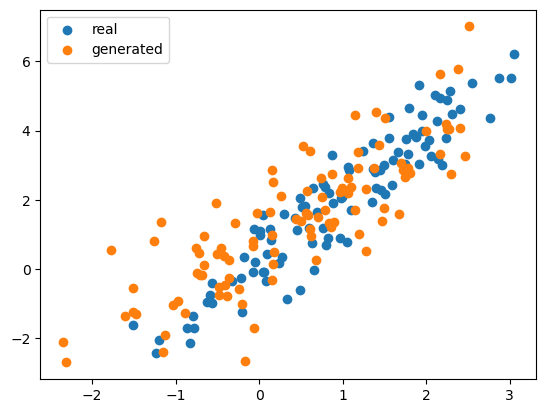

[Epoch 28/30] loss_D: 10.97288, loss_G: 11.38460


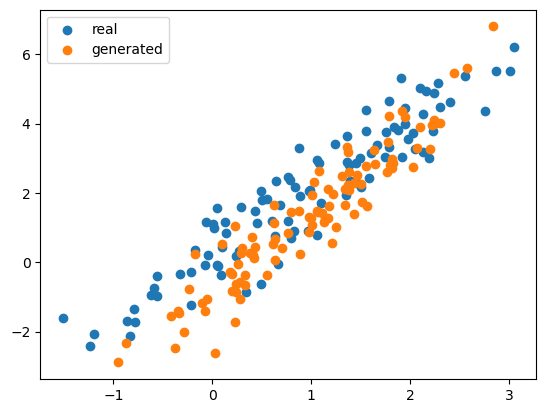

[Epoch 29/30] loss_D: 10.96931, loss_G: 11.24865


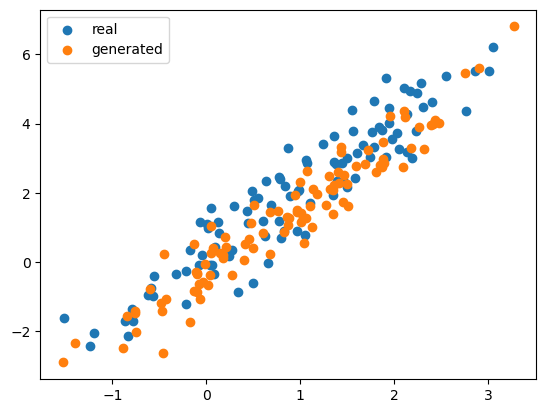

[Epoch 30/30] loss_D: 11.07676, loss_G: 11.04778


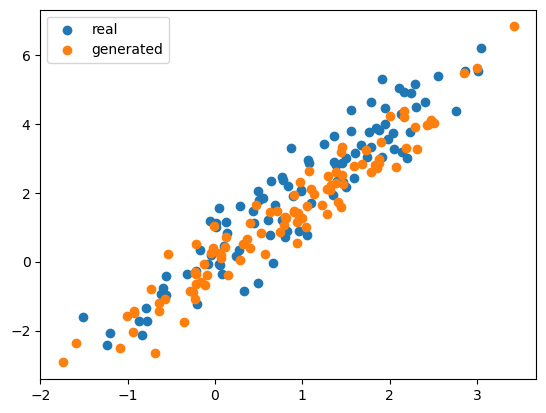

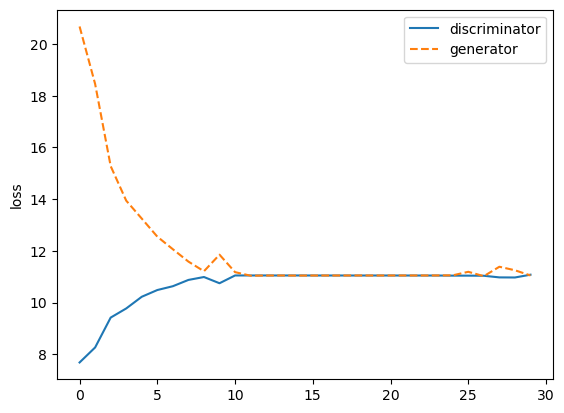

In [8]:
lr_D = 0.05
lr_G = 0.005
num_epochs = 20
D_trainer = torch.optim.Adam(discriminator.parameters(), 0.05)
G_trainer = torch.optim.Adam(generator.parameters(), 0.005)
criterion = nn.BCEWithLogitsLoss(reduction="sum")
num_epochs = 30
dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(data),
    batch_size=16, shuffle=True
)
fixed_noise = torch.normal(0, 1, size=(100, latent_dim))
train_gan(discriminator, generator, dataloader, data[:100], num_epochs, lr_G, lr_D, latent_dim, visualize=True, print_every=25, fixed_noise=fixed_noise)